<a href="https://colab.research.google.com/github/ballmdr/Machine-Learning/blob/master/Forex_Prediction_Neural_Network_Pure_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
filename = '/content/drive/My Drive/export/M30_all_EURUSD.csv'
df = pd.read_csv(filename, names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Datetime'] = pd.to_datetime(df.Date + ' ' + df.Time)
df.set_index('Datetime', inplace=True)

# Features for Momentum Strategy
df['Returns'] = - df.Close.pct_change(-1)

df['MA35'] = df.Close.rolling(35).mean()
df['MA70'] = df.Close.rolling(70).mean()
df['MA200'] = df.Close.rolling(200).mean()

# ma35 > ma70 = bullish
df['35_70'] = np.where(df.MA35 >= df.MA70, 1, 0)

# price > ma200 = bullish
df['bias_trend'] = np.where(df.Close.values >= df.MA200, 1, 0) 

df['body_candles'] = df.Open - df.Close
df['high_low'] = df.High - df.Low

df.dropna(inplace=True)

def norm_features(x):
  return (x - x.mean()) / (x.max() - x.min())

# normalize
df['Returns'] = norm_features(df.Returns)
df['Volume'] = norm_features(df.Volume)
df['body_candles'] = norm_features(df.body_candles)
df['high_low'] = norm_features(df.high_low)

df['Target'] = np.ones((len(df)))
df['Target'].loc[df.Returns > df.Returns.quantile(.80)] = 2
df['Target'].loc[df.Returns < df.Returns.quantile(.20)] = 0

df.drop(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Returns', 'MA35', 'MA70', 'MA200'], axis=1, inplace=True)

X = df.drop('Target', axis=1).values
Y = df.Target.values


# convert y into categorical
K = 3
from keras.utils import to_categorical
Y = to_categorical(Y, num_classes=K)

# split train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

print('train shape: ', x_train.shape)
print('test shape: ', x_test.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
Using TensorFlow backend.


train shape:  (135548, 5)
test shape:  (58093, 5)


0 cost:  2.06118159979107
10 cost:  0.3626930417471763
20 cost:  0.33585621023697093
30 cost:  0.330687548153281
40 cost:  0.3312373597653231
50 cost:  0.3303519969972137
60 cost:  0.3266365864454988
70 cost:  0.32364459351746805
80 cost:  0.32135284169071127
90 cost:  0.31958719420149323
100 cost:  0.31820009475437305
110 cost:  0.31706781451848615
120 cost:  0.3160961192138791
130 cost:  0.315225422618304
140 cost:  0.3144248793135345
150 cost:  0.3136802963288837
160 cost:  0.3129846740923288
170 cost:  0.3123336160287905
180 cost:  0.31172370281991796
190 cost:  0.311152004205465
200 cost:  0.31061591927478543
210 cost:  0.31011310177403406
220 cost:  0.30964141234874815
230 cost:  0.30919888411745045
240 cost:  0.30878369698285724
250 cost:  0.30839415814967575
260 cost:  0.3080286871274164
270 cost:  0.307685803992772
280 cost:  0.3073641200325589
290 cost:  0.3070623301356621
300 cost:  0.3067792064796393
310 cost:  0.30651359318448695
320 cost:  0.3062644016967079
330 cost:  0.

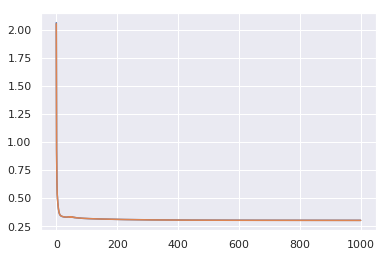

Train score:  0.6028417977395462
Test score:  0.6015871103231026


In [3]:
# build Neural Network using Numpy

def softmax(a):
  a = np.exp(a)
  return a / a.sum(axis=1, keepdims=True)

def cross_entropy(t, y):
  return - np.mean(t * np.log(y))

def model_score(t, y):
  return np.round(np.mean(t == y)*100, 2)

def predict(y):
  return np.argmax(y, axis=1)


D = X.shape[1]
hidden_layer = 64
lr = 0.000001
epochs = 1000

w1 = np.random.randn(D, hidden_layer)
b1 = np.random.randn(hidden_layer)
w2 = np.random.randn(hidden_layer, K)
b2 = np.random.randn(K)

train_costs = []
test_costs = []

for i in range(epochs):
  # train
  z_train = np.tanh(x_train.dot(w1) + b1)
  y_pred_train = softmax(z_train.dot(w2) + b2)
  cost_train = cross_entropy(y_train, y_pred_train)
  train_costs.append(cost_train)
  
  # test
  z_test = np.tanh(x_test.dot(w1) + b1)
  y_pred_test = softmax(z_test.dot(w2) + b2)
  cost_test = cross_entropy(y_test, y_pred_test)
  test_costs.append(cost_test)
  
  if i % 10 == 0:
    print(i, 'cost: ', cost_train)
  
  delta = y_train - y_pred_train
  w2 += z_train.T.dot(delta) * lr
  b2 += np.sum(delta) * lr
  
  dz = delta.dot(w2.T) * (1 - np.power(z_train, 2))
  
  w1 += x_train.T.dot(dz) * lr
  b1 += np.sum(dz) * lr
  
  
plt.plot(train_costs)
plt.plot(test_costs)
plt.show()

print('Train score: ', model_score(predict(y_train), predict(y_pred_train)))
print('Test score: ', model_score(predict(y_test), predict(y_pred_test)))
  
  


In [14]:
# lastest weight
print('w1', w1)
print('b1', b1)
print('w2', w2)
print('b2', b2)

w1 [[ 1.79371087  1.07077856 -0.21281622  0.26305711  0.44667068  1.37783456
   1.18006499  1.16949117  0.61277185  0.38676648  0.6161135   2.54637027
  -0.01445924  0.34764655 -0.70405338  0.28392768  0.76154265  0.072615
  -3.04831553 -1.09185298 -1.09718712 -0.10330902 -0.80162761  0.51508477
  -0.24680124  0.49751665  0.88780877  1.82636859  0.15311879  0.24152141
   0.60171631  0.78126713 -0.83873229 -0.33003845  1.41240874  0.26264324
  -0.44137611 -0.0383305   0.85721117 -0.30077185  0.48688588 -0.63727715
  -0.37198376  2.77823126 -0.66832923 -1.62387189 -0.11025681  1.79932871
   0.24534953 -0.66939301 -0.44475782 -0.61951508  0.52200235 -0.77551826
  -0.13129916  2.51021502  1.17382059  0.45243578 -1.45901688  0.34200952
  -2.33578347  0.01898834 -1.56682751 -2.67837392]
 [-1.93274691 -0.09147809  0.16235576  0.00496338 -2.02306294  2.46806424
   0.86541561  0.88041296  0.49096671 -1.28932098  0.49491711  1.23022623
   0.60933804  1.60901616  0.72442038  0.88605031 -0.6490464

In [0]:
# use keras for comparision
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss', mode='min')

model = Sequential([
    Dense(64, input_shape=(X.shape[1],), activation=tf.nn.tanh),
    Dense(K, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=1000, callbacks=[early_stop], validation_split=0.3, validation_data=(x_test, y_test), batch_size=32, verbose=1)
model.evaluate(x_final, y_final)

def history_plot(histories, key='acc'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()

        plt.xlim([0,max(history.epoch)])
        
history_plot(('model', history))

Train on 135548 samples, validate on 58093 samples
Epoch 1/1000
135548/135548 [==============================] - 18s 135us/sample - loss: 1.1115 - acc: 0.3748 - val_loss: 1.0907 - val_acc: 0.3884
Epoch 2/1000
135548/135548 [==============================] - 18s 132us/sample - loss: 1.0720 - acc: 0.5288 - val_loss: 1.0555 - val_acc: 0.5499
Epoch 3/1000
135548/135548 [==============================] - 18s 132us/sample - loss: 1.0399 - acc: 0.5910 - val_loss: 1.0275 - val_acc: 0.5956
Epoch 4/1000
135548/135548 [==============================] - 18s 133us/sample - loss: 1.0148 - acc: 0.5983 - val_loss: 1.0062 - val_acc: 0.5979
Epoch 5/1000
135548/135548 [==============================] - 18s 132us/sample - loss: 0.9963 - acc: 0.5993 - val_loss: 0.9910 - val_acc: 0.5983
Epoch 6/1000
135548/135548 [==============================] - 18s 132us/sample - loss: 0.9834 - acc: 0.5997 - val_loss: 0.9807 - val_acc: 0.5988
Epoch 7/1000
135548/135548 [==============================] - 18s 132us/sample 